In [77]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

NX = 9
NY = 6
OFFSET = 0

In [78]:
def collectCorners(imageFiles, nx, ny):
    '''
    '''
    objPoints = []
    imagePoints = []

    objPoint = np.zeros((ny*nx,3), np.float32)
    objPoint[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for imageFile in imageFiles:
        image = cv2.imread(imageFile)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objPoints.append(objPoint)
            imagePoints.append(corners)
            
    return objPoints,imagePoints

def undistort(image, objPoints, imagePoints):
    '''
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, (image.shape[1], image.shape[0]), None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)

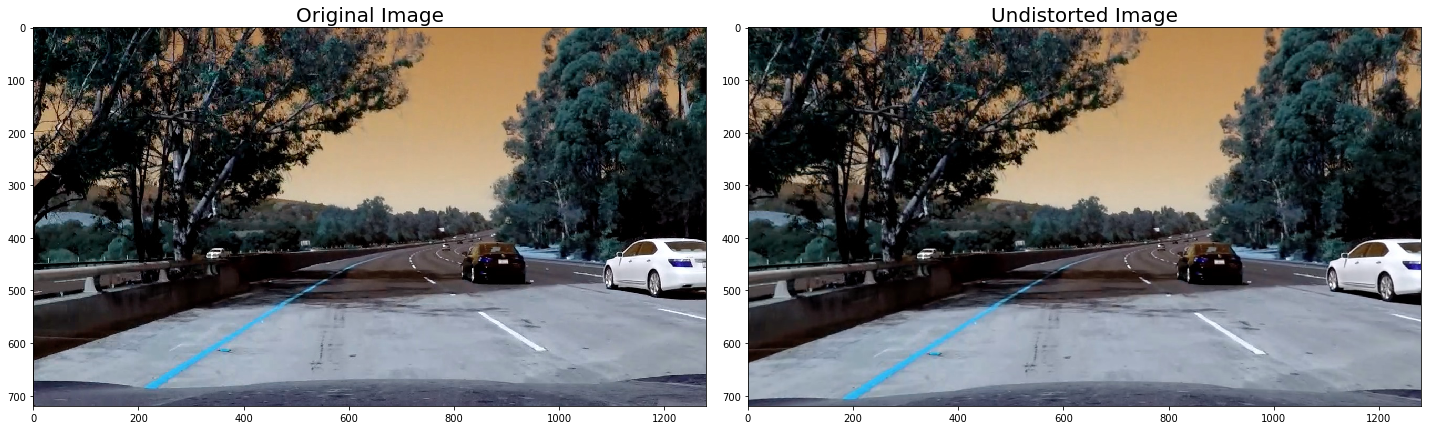

In [79]:
imageFiles = glob.glob('camera_cal/*.jpg')
objPoints,imagePoints = collectCorners(imageFiles, NX, NY)

image = cv2.imread('test_images/test5.jpg')
undistorted = undistort(image, objPoints, imagePoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

In [80]:
def thresholdColorGradient(undistorted, sThreshold=(130,255), xThreshold=(15,100)):
    '''
    '''
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]

    # Sobel x
    # Take the derivative in x
    # Absolute x derivative to accentuate lines away from horizontal
    sobelX = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0)
    absSobelX = np.absolute(sobelX)
    xSobel = np.uint8(255 * absSobelX/np.max(absSobelX))

    # Threshold x gradient
    xBinary = np.zeros_like(xSobel)
    xBinary[(xThreshold[0] <= xSobel) & (xSobel <= xThreshold[1])] = 1

    # Threshold color channel
    sBinary = np.zeros_like(sChannel)
    sBinary[(sThreshold[0] <= sChannel) & (sChannel <= sThreshold[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    colorBinary = np.dstack((np.zeros_like(xBinary), xBinary, sBinary))

    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(xBinary)
    combinedBinary[(sBinary == 1) | (xBinary == 1)] = 1

    return colorBinary,combinedBinary

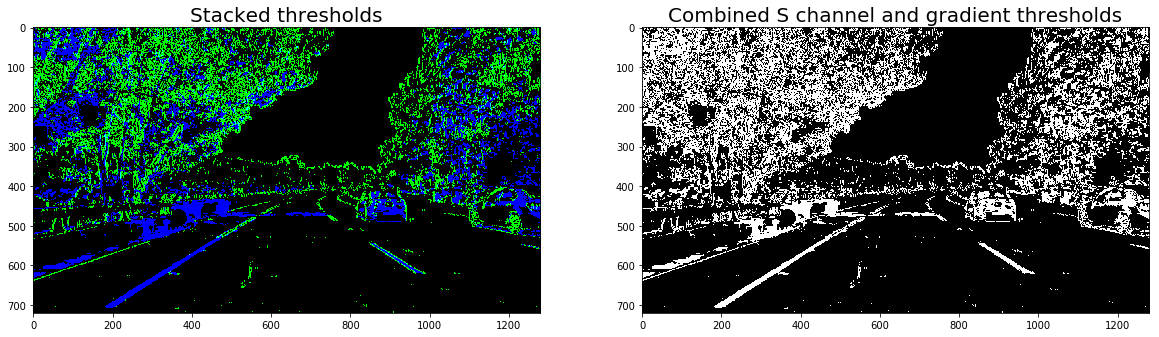

In [81]:
colorBinary,combinedBinary = thresholdColorGradient(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds', fontsize=20)
ax1.imshow(colorBinary)

ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax2.imshow(combinedBinary, cmap='gray')

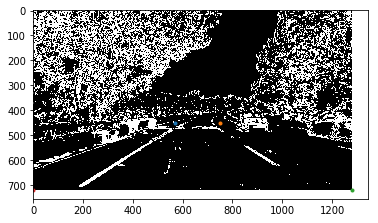

In [82]:
imageSize = (combinedBinary.shape[1], combinedBinary.shape[0]) 

upperLeft = [570, 450]
upperRight = [750, 450]
lowerRight = [imageSize[0], imageSize[1]]
lowerLeft = [0, imageSize[1]]

plt.imshow(combinedBinary, cmap='gray')
plt.plot(upperLeft[0],upperLeft[1],".")
plt.plot(upperRight[0],upperRight[1],".")
plt.plot(lowerRight[0], lowerRight[1], ".")
plt.plot(lowerLeft[0], lowerRight[1], ".")

In [83]:
def warp(undistorted, offset=OFFSET):
    '''
    '''
    imageSize = (undistorted.shape[1], undistorted.shape[0]) 
    
    srcRegion = [upperLeft,
                 upperRight,
                 lowerRight,
                 lowerLeft]
    
    dstRegion = [[offset, offset],
                 [imageSize[0]-offset, offset], 
                 [imageSize[0]-offset, imageSize[1]-offset], 
                 [offset, imageSize[1]-offset]]
    
    # Choose some points to be a nice fit for displaying the warped result for destination points    
    src = np.float32(srcRegion)
    dst = np.float32(dstRegion)
    
    # Calculate the perspective transform matrix given src and dst points, and
    # Warp the image using OpenCV warpPerspective()
    perspective = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, perspective, imageSize, flags=cv2.INTER_LINEAR)
    
    return warped

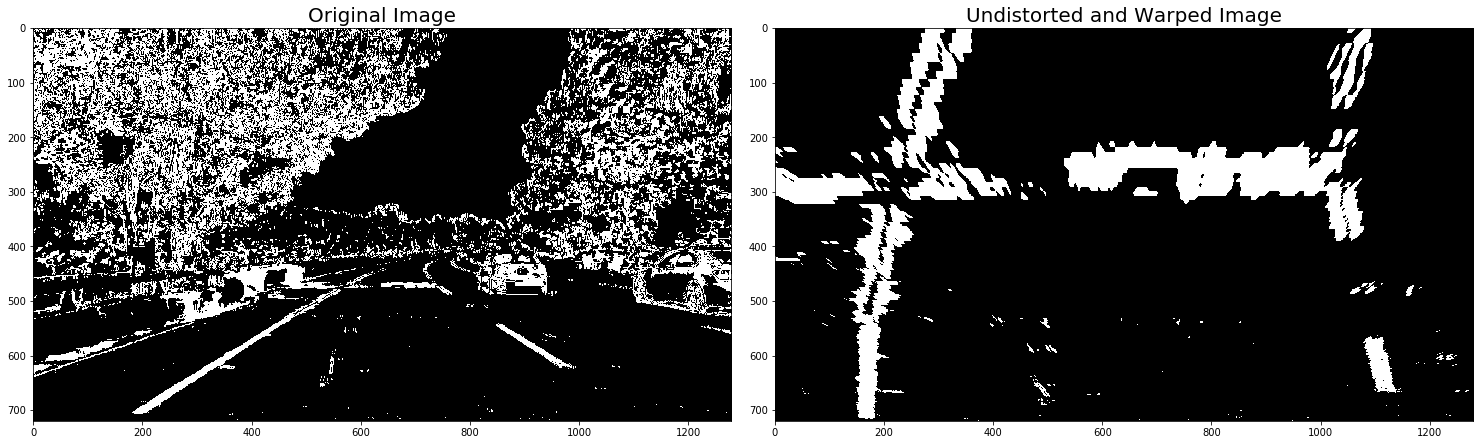

In [84]:
warped = warp(combinedBinary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(combinedBinary, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

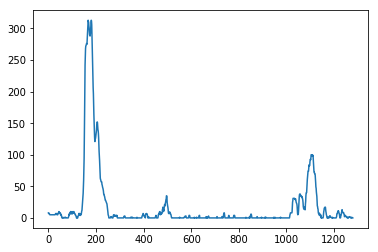

In [85]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [86]:
def measureCarvature(leftX, leftY, rightX, rightY, plotY):
    '''
    '''
    def curveRadius(fit, yValue, yMeterPerPixels):
        return ((1 + (2 * fit[0] * yValue * yMeterPerPixels + fit[1])**2)**1.5) / np.absolute(2 * fit[0])

    xMeterPerPixels = 3.7/700 # meters per pixel in x dimension    
    yMeterPerPixels = 30/720 # meters per pixel in y dimension

    # Fit new polynomials to x,y in world space
    leftFit = np.polyfit(leftY * yMeterPerPixels, leftX * xMeterPerPixels, 2)
    rightFit = np.polyfit(rightY * yMeterPerPixels, rightX * xMeterPerPixels, 2)
    
    # Calculate the new radii of curvature
    yValue = np.max(plotY)    
    leftCurveRadius = curveRadius(leftFit, yValue, yMeterPerPixels)
    rightCurveRadius = curveRadius(rightFit, yValue, yMeterPerPixels)
    
    # Now our radius of curvature is in meters
    return leftCurveRadius, rightCurveRadius

In [87]:
def findLanes(warped, numberOfWindows=9, windowMargin=100, minPixels=50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    output = np.dstack((warped, warped, warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midPoint = np.int(histogram.shape[0]/2)
    leftBaseX = np.argmax(histogram[:midPoint])
    rightBaseX = np.argmax(histogram[midPoint:]) + midPoint

    # Set height of windows
    windowHeight = np.int(warped.shape[0]/numberOfWindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftCurrentX = leftBaseX
    rightCurrentX = rightBaseX

    # Create empty lists to receive left and right lane pixel indices
    leftLaneIndices = []
    rightLaneIndices = []

    # Step through the windows one by one
    for index in range(numberOfWindows):
        # Identify window boundaries in x and y (and right and left)
        lowY = warped.shape[0] - (index+1) * windowHeight
        highY = warped.shape[0] - index * windowHeight
        leftLowX = leftCurrentX - windowMargin
        leftHighX = leftCurrentX + windowMargin
        rightLowX = rightCurrentX - windowMargin
        rightHighX = rightCurrentX + windowMargin
        
        # Identify the nonzero pixels in x and y within the window
        def nonzeroIndices(lowX, highX, lowY, highY, nonzeroX, nonzeroY):
            return ((lowY <= nonzeroY) & (nonzeroY < highY) & (lowX <= nonzeroX) & (nonzeroX < highX)).nonzero()[0]
            
        leftNonzeroIndices = nonzeroIndices(leftLowX, leftHighX, lowY, highY, nonzeroX, nonzeroY)
        rightNonzeroIndices = nonzeroIndices(rightLowX, rightHighX, lowY, highY, nonzeroX, nonzeroY)
        
        # Append these indices to the lists
        leftLaneIndices.append(leftNonzeroIndices)
        rightLaneIndices.append(rightNonzeroIndices)
        
        # If you found > minPixels pixels, recenter next window on their mean position
        if minPixels < len(leftNonzeroIndices):
            leftCurrentX = np.int(np.mean(nonzeroX[leftNonzeroIndices]))
            
        if minPixels < len(rightNonzeroIndices):
            rightCurrentX = np.int(np.mean(nonzeroX[rightNonzeroIndices]))

    # Concatenate the arrays of indices
    leftLaneIndices = np.concatenate(leftLaneIndices)
    rightLaneIndices = np.concatenate(rightLaneIndices)
    
    # Extract left and right line pixel positions
    leftX = nonzeroX[leftLaneIndices]
    leftY = nonzeroY[leftLaneIndices]
    rightX = nonzeroX[rightLaneIndices]
    rightY = nonzeroY[rightLaneIndices]
    
    # Fit a second order polynomial to each
    leftFit = np.polyfit(leftY, leftX, 2)
    rightFit = np.polyfit(rightY, rightX, 2)
    
    ###
    
    def laneIndices(fit, nonzeroX, nonzeroY, margin):
        return (((fit[0]*(nonzeroY**2) + fit[1]*nonzeroY + fit[2] - margin) < nonzeroX) &
                (nonzeroX < (fit[0]*(nonzeroY**2) + fit[1]*nonzeroY + fit[2] + margin))) 
    
    leftLaneIndices = laneIndices(leftFit, nonzeroX, nonzeroY, windowMargin)
    rightLaneIndices = laneIndices(rightFit, nonzeroX, nonzeroY, windowMargin)
    
    # Again, extract left and right line pixel positions
    leftX = nonzeroX[leftLaneIndices]
    leftY = nonzeroY[leftLaneIndices]
    rightX = nonzeroX[rightLaneIndices]
    rightY = nonzeroY[rightLaneIndices]
    
    # Fit a second order polynomial to each
    leftFit = np.polyfit(leftY, leftX, 2)
    rightFit = np.polyfit(rightY, rightX, 2)
    
    # Generate x and y values for plotting
    plotY = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    leftFitX = leftFit[0] * plotY**2 + leftFit[1] * plotY + leftFit[2]
    rightFitX = rightFit[0] * plotY**2 + rightFit[1] * plotY + rightFit[2]
    
    # Measure curvature here
    leftCurveRadius,rightCurveRadius = measureCarvature(leftX, leftY, rightX, rightY, plotY)
    
    # Draw the image
    windowImage = np.zeros_like(output)
    
    # Color in left and right line pixels
    output[nonzeroY[leftLaneIndices], nonzeroX[leftLaneIndices]] = [255, 0, 0]
    output[nonzeroY[rightLaneIndices], nonzeroX[rightLaneIndices]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX - windowMargin, plotY]))])
    leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX + windowMargin, plotY])))])
    leftLinePoints = np.hstack((leftLineWindow1, leftLineWindow2))
    
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX - windowMargin, plotY]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX + windowMargin, plotY])))])
    rightLinePoints = np.hstack((rightLineWindow1, rightLineWindow2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(windowImage, np.int_([leftLinePoints]), (0,255, 0))
    cv2.fillPoly(windowImage, np.int_([rightLinePoints]), (0,255, 0))
    lanes = cv2.addWeighted(output, 1, windowImage, 0.3, 0)
    
    return lanes,leftFitX,rightFitX,plotY,leftCurveRadius,rightCurveRadius

508.584550698 m, 162.723063698 m


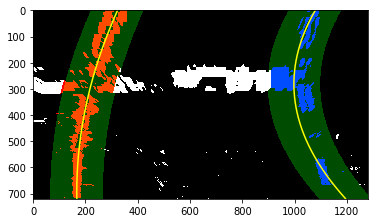

In [88]:
lanes,leftFitX,rightFitX,plotY,leftCurveRadius,rightCurveRadius = findLanes(warped)

plt.imshow(lanes)
plt.plot(leftFitX, plotY, color='yellow')
plt.plot(rightFitX, plotY, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print(leftCurveRadius, 'm,', rightCurveRadius, 'm')